In [1]:
%matplotlib inline

In [2]:
import os, sys
import glob
import re
import math
import time
import numpy as np
from uncertainties import unumpy as unp
import uncertainties.umath as umath
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat

In [3]:
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 1.5

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# unit conversion
# 1 Ha = 4.3597482*e-18 J
# 1 angstrom = 1.0*10e-10 m
# 1 atomic unit = 1.66057*10e-27 kg
# 1 THz = 33.35641 cm-1
Ry_to_J=2.17987 * 10**-18
Ha_to_J=Ry_to_J * 2.0
J_to_Ha=1.0/Ha_to_J
aumass_to_kg=1.66054*10**-27
bohr_to_m=5.29177210903*10**-11
bohr_to_ang=0.529177210903
ang_to_bohr=1.0/bohr_to_ang
m_to_bohr=1.0/bohr_to_m
au_to_GPa = (4.359e-18)/(0.5291772e-10)**3 * (10**-9)
KBar_to_Ha_bohr = 10**8 * J_to_Ha / (m_to_bohr)**3
Ha_bohr_to_KBar = 1.0 / KBar_to_Ha_bohr
# au_to_GPa = 1 a.u. = 1 Hartree/(1 Bohr)^3 = (4.359e-18 J)/(0.5291772e-10 m)^3 * (10**-12)

In [6]:
try:
    import ipynb_path
    root_dir = os.path.dirname(ipynb_path.get())
except ModuleNotFoundError:
    root_dir = '/mnt/data/kosuke/45jQMC/XX'
os.chdir(root_dir)
root_dir

'/Users/kosuke/applications/jQMC/examples/example02'

In [14]:
# def read
def read_lrdmc_num_branching(file):
    with open(file, "r") as f:
        lines=f.readlines()
        for line in lines:
            if re.match('.*Total.*GFMC.*time.*for.*', line):
                num_gfmc_steps=float(line.split()[4])
                return num_gfmc_steps
        return np.nan

In [23]:
# def read
def read_lrdmc_elapsed_time(file):
    with open(file, "r") as f:
        lines=f.readlines()
        for line in lines:
            if re.match('.*Net.*GFMC.*time.*without.*pre-compilations.*', line):
                elapsed_time=float(line.split()[6])
                return elapsed_time
        return np.nan

In [24]:
# def read
def read_num_MPI_processes(file):
    with open(file, "r") as f:
        lines=f.readlines()
        for line in lines:
            if re.match('.*The.*number.*of.*MPI.*process.*', line):
                num_MPI_processes=int(float(line.split()[6]))
                return num_MPI_processes
        return np.nan

In [25]:
# def read
def read_num_nw_for_each_MPI(file):
    with open(file, "r") as f:
        lines=f.readlines()
        for line in lines:
            if re.match('.*The.*number.*of.*walkers.*assigned.*for.*each.*MPI.*process.*', line):
                num_nw_for_each_MPI=int(float(line.split()[10]))
                return num_nw_for_each_MPI
        return np.nan

In [69]:
mol_list = ['01water_jqmc', '02acetic_acid_jqmc']
mol_label_list = [r'Water ($N_e = 8$)', r'Acetic Acid ($N_e = 24$)']
summary = {}

# files
out_lrdmc_cpu='out_lrdmc0_on_cpu'
out_lrdmc_gpu='out_lrdmc0_on_gpu'

for mol in mol_list:
    # dirs
    cpu_dirs = glob.glob(os.path.join(root_dir, mol, 'on_cpu', 'node_*'))
    gpu_dirs = glob.glob(os.path.join(root_dir, mol, 'on_gpu', 'node_*'))
    # cpu part, LRDMC
    lrdmc_num_branching_cpu_np=np.array([read_lrdmc_num_branching(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs])
    lrdmc_elapsed_time_cpu_np = np.array([read_lrdmc_elapsed_time(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs])
    lrdmc_num_MPI_processes_cpu_np = np.array([read_num_MPI_processes(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs])
    lrdmc_num_nw_for_each_MPI_cpu_np = np.array([read_num_nw_for_each_MPI(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs])
    lrdmc_num_total_nw_cpu_np = lrdmc_num_MPI_processes_cpu_np * lrdmc_num_nw_for_each_MPI_cpu_np
    lrdmc_num_projections_num_walkers_per_sec_cpu_np = lrdmc_num_total_nw_cpu_np * lrdmc_num_branching_cpu_np/lrdmc_elapsed_time_cpu_np
    lrdmc_label_cpu_np = [f'({num_MPI}MPI, {num_nw}Nw)' for num_MPI, num_nw in zip(lrdmc_num_MPI_processes_cpu_np, lrdmc_num_nw_for_each_MPI_cpu_np)]
    
    # GPU part, LRDMC
    lrdmc_num_branching_gpu_np=np.array([read_lrdmc_num_branching(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs])
    lrdmc_elapsed_time_gpu_np = np.array([read_lrdmc_elapsed_time(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs])
    lrdmc_num_MPI_processes_gpu_np = np.array([read_num_MPI_processes(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs])
    lrdmc_num_nw_for_each_MPI_gpu_np = np.array([read_num_nw_for_each_MPI(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs])
    lrdmc_num_total_nw_gpu_np = lrdmc_num_MPI_processes_gpu_np * lrdmc_num_nw_for_each_MPI_gpu_np
    lrdmc_num_projections_num_walkers_per_sec_gpu_np = lrdmc_num_total_nw_gpu_np * lrdmc_num_branching_gpu_np/lrdmc_elapsed_time_gpu_np
    lrdmc_label_gpu_np = [f'({num_MPI}MPI, {num_nw}Nw)' for num_MPI, num_nw in zip(lrdmc_num_MPI_processes_gpu_np, lrdmc_num_nw_for_each_MPI_gpu_np)]

    summary[mol]={
        # LRDMC CPU part
        'lrdmc_num_branching_cpu_np': lrdmc_num_branching_cpu_np,
        'lrdmc_elapsed_time_cpu_np': lrdmc_elapsed_time_cpu_np,
        'lrdmc_num_MPI_processes_cpu_np': lrdmc_num_MPI_processes_cpu_np,
        'lrdmc_num_nw_for_each_MPI_cpu_np': lrdmc_num_nw_for_each_MPI_cpu_np,
        'lrdmc_num_total_nw_cpu_np': lrdmc_num_total_nw_cpu_np,
        'lrdmc_num_projections_num_walkers_per_sec_cpu_np': lrdmc_num_projections_num_walkers_per_sec_cpu_np,
        'lrdmc_label_cpu_np': lrdmc_label_cpu_np,
        # LRDMC GPU part
        'lrdmc_num_branching_gpu_np': lrdmc_num_branching_gpu_np, 
        'lrdmc_elapsed_time_gpu_np': lrdmc_elapsed_time_gpu_np,
        'lrdmc_num_MPI_processes_gpu_np': lrdmc_num_MPI_processes_gpu_np,
        'lrdmc_num_nw_for_each_MPI_gpu_np': lrdmc_num_nw_for_each_MPI_gpu_np,
        'lrdmc_num_total_nw_gpu_np': lrdmc_num_total_nw_gpu_np,
        'lrdmc_num_projections_num_walkers_per_sec_gpu_np': lrdmc_num_projections_num_walkers_per_sec_gpu_np,
        'lrdmc_label_gpu_np': lrdmc_label_gpu_np
    }

In [71]:
summary

{'01water_jqmc': {'lrdmc_num_branching_cpu_np': array([100., 100., 100., 100., 100., 100., 100., 100.]),
  'lrdmc_elapsed_time_cpu_np': array([163.579, 694.334,  54.149,  37.938,  88.018,  64.265, 264.96 ,
          59.107]),
  'lrdmc_num_MPI_processes_cpu_np': array([  4,   1,  30, 120,  10,  20,   2,  60]),
  'lrdmc_num_nw_for_each_MPI_cpu_np': array([ 30, 120,   4,   1,  12,   6,  60,   2]),
  'lrdmc_num_total_nw_cpu_np': array([120, 120, 120, 120, 120, 120, 120, 120]),
  'lrdmc_num_projections_num_walkers_per_sec_cpu_np': array([ 73.35904976,  17.28274865, 221.61074073, 316.30555116,
         136.33574951, 186.7268342 ,  45.28985507, 203.02163872]),
  'lrdmc_label_cpu_np': ['(4MPI, 30Nw)',
   '(1MPI, 120Nw)',
   '(30MPI, 4Nw)',
   '(120MPI, 1Nw)',
   '(10MPI, 12Nw)',
   '(20MPI, 6Nw)',
   '(2MPI, 60Nw)',
   '(60MPI, 2Nw)'],
  'lrdmc_num_branching_gpu_np': array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100.]),
  'lrdmc_elapsed_time_gpu_

speed-up by GPU for 01water_jqmc is 17.16.
speed-up by GPU for 02acetic_acid_jqmc is nan.


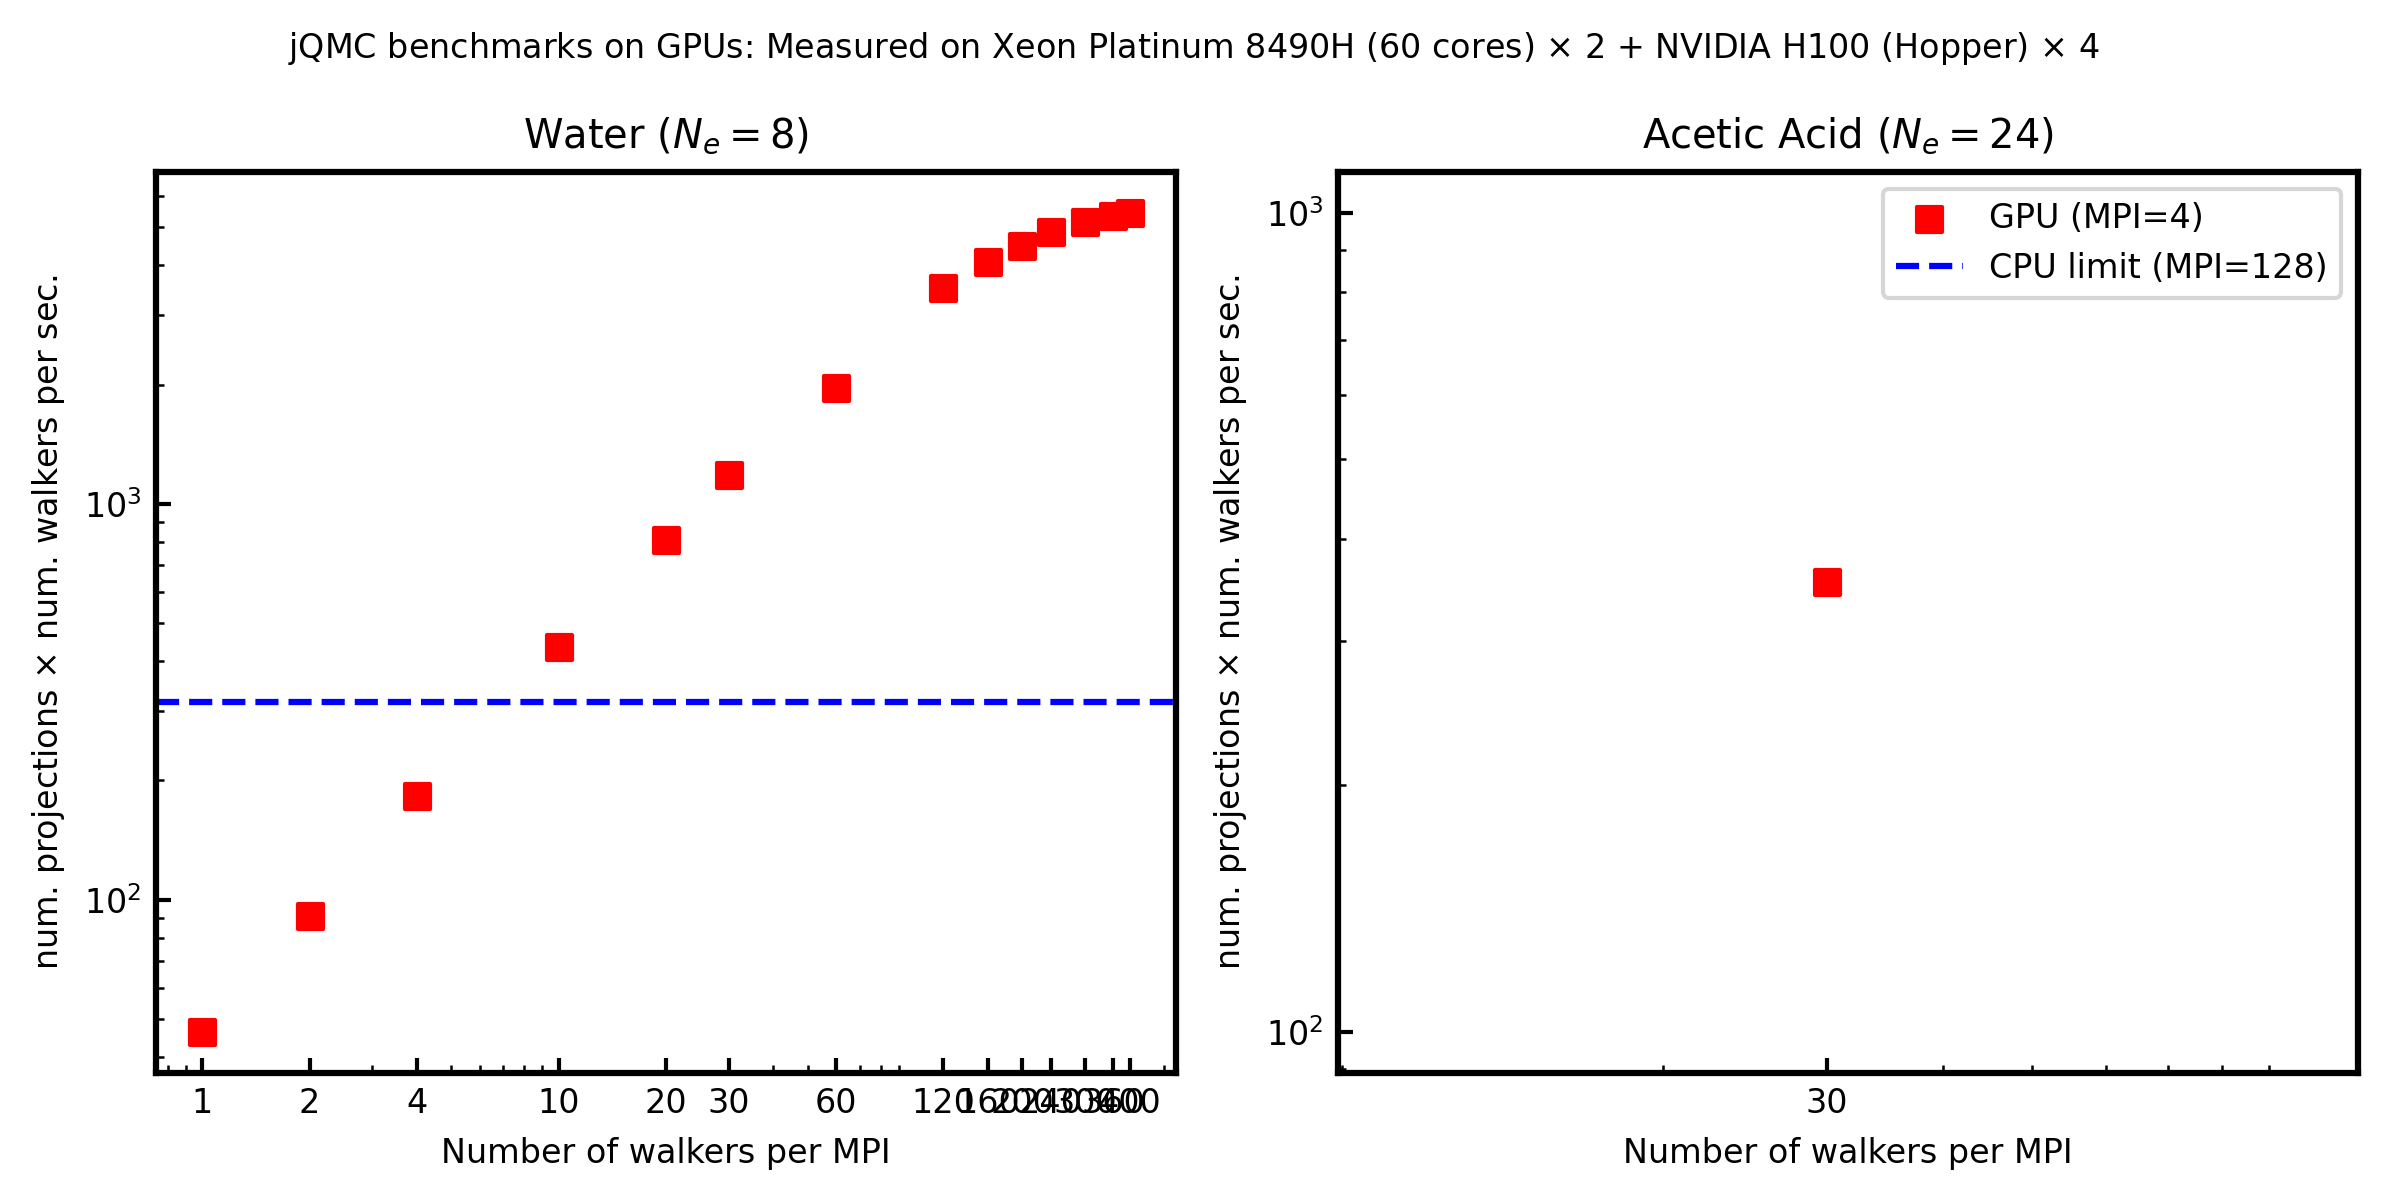

In [79]:
#plot Graph
fig = plt.figure(figsize=(4*len(mol_list), 4), facecolor='white', dpi=300, tight_layout=True)
fig.suptitle(fr'jQMC benchmarks on GPUs: Measured on Xeon Platinum 8490H (60 cores) $\times$ 2 + NVIDIA H100 (Hopper) $\times$ 4', fontsize=8)

for i, mol in enumerate(mol_list):
    #plot Graph
    ax = fig.add_subplot(1,len(mol_list),i+1)
    
    # labels
    ax.set_title(mol_label_list[i], wrap=True)
    ax.set_xlabel('Number of walkers per MPI')
    ax.set_ylabel(r'num. projections $\times$ num. walkers per sec.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax2.set_ylim([y_min, y_max])
    
    # GPU
    x=summary[mol]['lrdmc_num_nw_for_each_MPI_gpu_np']
    y=summary[mol]['lrdmc_num_projections_num_walkers_per_sec_gpu_np']
    ax.scatter(x, y, color="r", marker="s", label="GPU (MPI=4)")
    ax.axhline(np.max(summary[mol]['lrdmc_num_projections_num_walkers_per_sec_cpu_np']), color="b", ls="--", label="CPU limit (MPI=128)")
    ax.set_xticks(summary[mol]['lrdmc_num_nw_for_each_MPI_gpu_np'])
    ax.set_xticklabels([str(t) for t in summary[mol]['lrdmc_num_nw_for_each_MPI_gpu_np']]) 

    print(f"speed-up by GPU for {mol} is {np.max(summary[mol]['lrdmc_num_projections_num_walkers_per_sec_gpu_np'])/np.max(summary[mol]['lrdmc_num_projections_num_walkers_per_sec_cpu_np']):.2f}.")

#plt.savefig(f'Si_Pressure_VMC.pdf')
plt.legend()
plt.show()

In [16]:
mols = ['Water', 'Acetic Acid', 'Benzene']
jqmc_lrdmc_projection_time_per_branching_per_walker_cpu_dict={
    'Water': 1.34405,
    'Acetic Acid': 1130.45135,
    'Benzene': 4486.208991666667
}
jqmc_lrdmc_projection_time_per_branching_per_walker_gpu_dict={
    'Water': 0.29027569444444445,
    'Acetic Acid': 36.56525,
    'Benzene': 107.81910833333333
}
turbo_lrdmc_projection_time_per_branching_per_walker_cpu_dict={
    'Water': 0.29 / 1000 / 120,
    'Acetic Acid': 37.50 / 1000 / 120,
    'Benzene': 50.25 / 1000 / 120
}

In [21]:
mols = ['Water']
x = mols
y_jqmc_cpu=[jqmc_lrdmc_projection_time_per_branching_per_walker_cpu_dict[mol] for mol in mols]
y_jqmc_gpu=[jqmc_lrdmc_projection_time_per_branching_per_walker_gpu_dict[mol] for mol in mols]
#y_turbo_cpu=[turbo_lrdmc_projection_time_per_branching_per_walker_cpu_dict[mol] for mol in mols]

# figure
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=300, tight_layout=True)
ax = fig.add_subplot(1,1,1)

# labels
x_index = np.arange(len(x))
ax.set_xticks(x_index)
ax.set_xticklabels(x)
ax.set_yscale('log')
ax.set_xlabel('Molecule')
ax.set_ylabel('LRDMC projection time per walker')
ax.set_title('Comparison of LRDMC Projection Time')

# plot
width = 0.25
ax.bar(x_index - width, y_jqmc_cpu, width=width, label='jQMC CPU')
ax.bar(x_index,         y_jqmc_gpu, width=width, label='jQMC GPU')
#ax.bar(x_index + width, y_turbo_cpu, width=width, label='TURBO CPU')

plt.legend()
plt.show()

NameError: name 'jqmc_lrdmc_projection_time_per_branching_per_walker_cpu_dict' is not defined